# Lecture 10: Text-Audio models

We provide a notebook with training, inference, and clustering code for text-audio models using contrastive learning and pre-trained models.

## Notebook steps:
1. Create datasaet of text and audio embeddings based on pre-trained models for the MusicCaps dataset
2. Visualize the orignal latent space
3. Train the text/audio model with contrastive learning, and visualize the aligned space
4. Evaluate on music retrieval using the SongDescriber dataset

In [1]:
!pip install torch
!pip install torchcodec
!pip install datasets[audio]==3
!pip install tqdm
!pip install scikit-learn
!pip install matplotlib
!pip install sentence-transformers
!pip install omar-rq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [32]:
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import omar_rq
import numpy as np
import umap
from datasets import load_dataset, Audio
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange
from torch.utils.data import DataLoader, Dataset
from torchaudio.transforms import Resample
from sentence_transformers import SentenceTransformer

device = "cuda"  # Configure depending on the runtime

## Step 1: Create datasaet of text and audio embeddings

In [3]:
# Use Datasets to load MusicCaps
ds = load_dataset("CLAPv2/MusicCaps")["train"]

# make random train/val splits
is_balanced = ds["is_balanced_subset"]
val_idx = [i for i, keep in enumerate(is_balanced) if eval(keep)]
train_idx = [i for i, keep in enumerate(is_balanced) if not eval(keep)]

ds_val = ds.select(val_idx)
ds_train = ds.select(train_idx)

print(f"number of train ids: {len(ds_train)}")
print(f"number of val ids: {len(ds_val)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


musiccaps_part_0.parquet:   0%|          | 0.00/927M [00:00<?, ?B/s]

musiccaps_part_1.parquet:   0%|          | 0.00/936M [00:00<?, ?B/s]

musiccaps_part_10.parquet:   0%|          | 0.00/628M [00:00<?, ?B/s]

musiccaps_part_2.parquet:   0%|          | 0.00/929M [00:00<?, ?B/s]

musiccaps_part_3.parquet:   0%|          | 0.00/930M [00:00<?, ?B/s]

musiccaps_part_4.parquet:   0%|          | 0.00/929M [00:00<?, ?B/s]

musiccaps_part_5.parquet:   0%|          | 0.00/932M [00:00<?, ?B/s]

musiccaps_part_6.parquet:   0%|          | 0.00/912M [00:00<?, ?B/s]

musiccaps_part_7.parquet:   0%|          | 0.00/918M [00:00<?, ?B/s]

musiccaps_part_8.parquet:   0%|          | 0.00/899M [00:00<?, ?B/s]

musiccaps_part_9.parquet:   0%|          | 0.00/894M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5352 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/18 [00:00<?, ?it/s]

number of train ids: 4383
number of val ids: 969


In [4]:
class TextAudioDataset(Dataset):
    "Text/audio dataset based on HuggingFace baseed on pre-computed embeddings"

    def __init__(self, dataset, device, tid_name="index", audio_name="audio"):
        self.dataset = dataset
        self.device =  device

        self.orig_sample_rate = 48000
        self.sample_rate = 24000
        self.max_duration = 30

        self.audio_model_id = "mtg-upf/clap_omarrq_mp_small_music"
        self.text_model_id = "sentence-transformers/all-mpnet-base-v2"

        self.resample = Resample(orig_freq=self.orig_sample_rate, new_freq=self.sample_rate)
        self.resample.to(self.device)

        self.audio_encoder = omar_rq.get_model(model_id=self.audio_model_id, device=self.device)
        self.audio_encoder.eval()

        # Select intermediate layers of the audio model
        self.layers = [6]

        self.text_encoder = SentenceTransformer(self.text_model_id, device=self.device)
        self.text_encoder.eval()

        # Load audio and labels
        self.tids = []
        self.audio_rep = {}
        self.text_rep = {}
        for track in tqdm(self.dataset, desc="Loading audio"):
            tid = track[tid_name]
            self.tids.append(tid)

            audio = track[audio_name]["array"]
            sr = track[audio_name]["sampling_rate"]
            audio = torch.tensor(audio, dtype=torch.float).to(self.device)
            audio.unsqueeze_(0)

            # Use 30s only if the audio is very long
            if audio.size(1) / sr > self.max_duration:
                max_samples = self.max_duration * sr
                start_sample = audio.size(1) // 2 - max_samples // 2
                audio = audio[:, start_sample:start_sample+max_samples]

            # Resample audio
            if sr != self.sample_rate:
                if sr != self.orig_sample_rate:
                    self.resample = Resample(orig_freq=sr, new_freq=self.sample_rate)
                    self.resample.to(self.device)
                    self.orig_sample_rate = sr
                audio = self.resample(audio.float())

            # Extract audio representations
            with torch.no_grad():
              x_a = self.audio_encoder.extract_embeddings(audio, layers=self.layers)

            # Average across layers, segments, and timestamps
            self.audio_rep[tid] = torch.mean(x_a, dim=[0, 1, 2])

            # Extract text representations
            text = track["caption"]
            x_t = self.text_encoder.encode(text, convert_to_tensor=True, device=self.device)
            self.text_rep[tid] = x_t

    def __len__(self):
        return len(self.tids)

    def __getitem__(self, idx):
        tid = self.tids[idx]

        return {"audio_rep": self.audio_rep[tid], "text_rep": self.text_rep[tid]}

In [33]:
train_dataset = TextAudioDataset(ds_train, device=device)
val_dataset = TextAudioDataset(ds_val, device=device)

OMAR-RQ: 396 weights loaded for `net`
OMAR-RQ: 2 weights loaded for `embedding_layer`


Loading audio: 100%|██████████| 4383/4383 [05:26<00:00, 13.43it/s]


### Step 2: Define the CLAP model and visualize latent space
Note that in this simple version it simply consistes on two linear projections that ensure same output dimensionality.

In [14]:
class CLAP(nn.Module):
    def __init__(
        self,
        a_rep_size: int=512,
        t_rep_size: int=512,
        embed_size: int=64,
    ):
        super().__init__()
        self.a_rep_size = a_rep_size
        self.t_rep_size = t_rep_size
        self.embed_size = embed_size

        self.proj_a = nn.Linear(self.a_rep_size, self.embed_size)
        self.proj_z = nn.Linear(self.t_rep_size, self.embed_size)

    def forward(self, x_a, x_t):
        z_a = self.proj_a(x_a)
        z_t = self.proj_z(x_a)

        return z_a, z_t

In [16]:
def plot_val_embeddings(model, device="cuda"):
    model.eval()
    embeddings = []
    natural_labels = []

    model.to(device)
    n_samples = len(val_dataset.tids)

    val_loader = DataLoader(val_dataset, batch_size=65, shuffle=False)
    for batch in val_loader:
        x_a = batch["audio_rep"].to(device)
        x_t = batch["text_rep"].to(device)

        with torch.no_grad():
            z_a, z_t = model(x_a, x_t)

        embeddings.append(z_a.cpu().numpy())
        embeddings.append(z_t.cpu().numpy())

        natural_labels.extend(["audio"] * x_a.size(0))
        natural_labels.extend(["text"] * x_a.size(0))

    embeddings = np.concat(embeddings, axis=0)
    natural_labels = np.array(natural_labels)

    # Perform UMAP
    reducer = umap.UMAP(n_components=2)
    umap_embeddings = reducer.fit_transform(embeddings)

    # Create UMAP plot
    unique_labels, label_indices = np.unique(natural_labels, return_inverse=True)

    cmap = matplotlib.cm.get_cmap("tab10", len(unique_labels))

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        umap_embeddings[:, 0],
        umap_embeddings[:, 1],
        c=label_indices,
        cmap=cmap,
    )

    handles, _ = scatter.legend_elements(prop="colors", num=len(unique_labels))
    plt.legend(handles, unique_labels, title="Labels")

    plt.title("UMAP of Audio Embeddings")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()

CLAP Trainable parameters: 262656


/tmp/ipython-input-2637274864.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap("tab10", len(unique_labels))


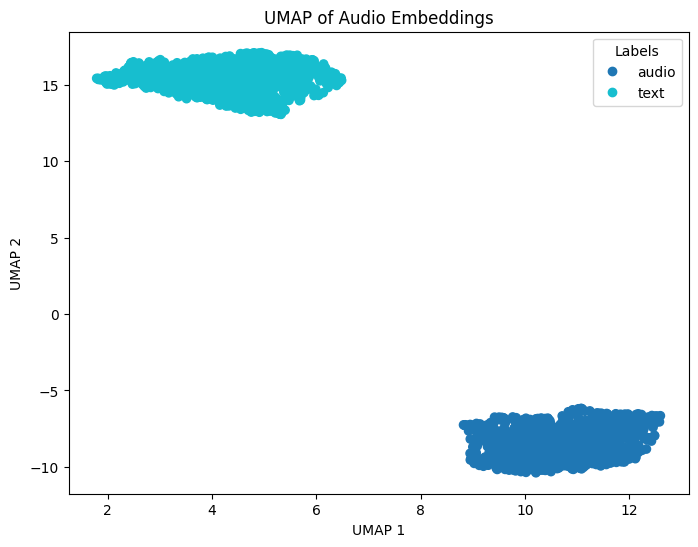

In [17]:
model = CLAP(a_rep_size=512, t_rep_size=512, embed_size=256).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"CLAP Trainable parameters: {num_params}")

plot_val_embeddings(model, device=device)

## Step 3: Train the model
Set up the training loop with loss functions and optimizers.


In [34]:
def step(batch, loss_fn, model, optimizer=None):
    x_a = batch["audio_rep"].to(device)
    x_t = batch["text_rep"].to(device)

    # Forward
    z_a, z_t = model(x_a, x_t)

    # Compute loss
    loss = loss_fn(z_a, z_t)
    step_loss = loss.item()

    # Backprop
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return step_loss

def train(
    model,
    train_dataset,
    val_dataset,
    loss_fn,
    n_epochs=3,
    lr=0.001,
    device="cuda",
    batch_size=32,
):
    # Use Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    pbar = trange(n_epochs, desc="Training", total=n_epochs)
    for epoch in range(n_epochs):
        # Training loop

        model.train()
        total_loss = 0.0
        for batch in train_loader:
            step_loss = step(batch, loss_fn, model, optimizer)
            total_loss += step_loss

        train_loss = total_loss / len(train_loader)

        # Validation loop
        model.eval()
        total_loss = 0
        for batch in val_loader:
            step_loss = step(batch, loss_fn, model)
            total_loss += step_loss

        val_loss = total_loss / len(val_loader)

        pbar.set_postfix({
            # "epoch": f"{epoch+1}",
            "train loss": f"{train_loss:.3f}",
            "val loss": f"{val_loss:.3f}",
        })
        pbar.update(1)

In [35]:
def InfoNCE(z_1, z_2, temp=0.5):
    # Normalize the embeddings
    z_1 = F.normalize(z_1, dim=1)
    z_2 = F.normalize(z_2, dim=1)

    # Similarity matrices
    sim_12 = torch.matmul(z_1, z_2.T)  # z1 as anchor, z2 as candidates
    sim_21 = torch.matmul(z_2, z_1.T)  # z2 as anchor, z1 as candidates

    # Labels: each sample i should match its own pair i
    labels = torch.arange(sim_12.size(0)).to(sim_12.device)

    # InfoNCE losses (both directions)
    loss_12 = F.cross_entropy(sim_12 / temp, labels)
    loss_21 = F.cross_entropy(sim_21 / temp, labels)

    # Symmetric SimCLR loss
    return 0.5 * (loss_12 + loss_21)


Training model with the triplet loss


Training: 100%|██████████| 20/20 [00:04<00:00,  4.25it/s, train loss=2.289, val loss=2.229]
/tmp/ipython-input-2637274864.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap("tab10", len(unique_labels))


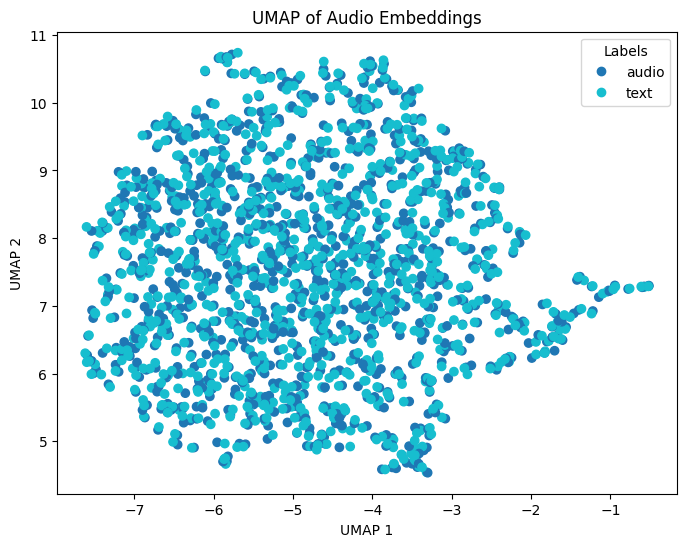

In [36]:
model = CLAP(a_rep_size=512, t_rep_size=512, embed_size=256).to(device)

print("\nTraining model with the triplet loss")
train(model, train_dataset, val_dataset, InfoNCE, n_epochs=20, device=device, batch_size=64)
plot_val_embeddings(model, device=device)

In [8]:
ds_eval = load_dataset("renumics/song-describer-dataset")["train"]

  # make random train/val splits
is_valid = ds_eval["is_valid_subset"]
valid_idx = [i for i, keep in enumerate(is_valid) if keep]

ds_eval = ds_eval.select(valid_idx)
print("Eval size", len(ds_eval))

ds_eval = ds_eval.cast_column("path", Audio(sampling_rate=24000))

eval_dataset = TextAudioDataset(ds_eval, device=device, tid_name="track_id", audio_name="path")

batch_size = 128
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/316M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/297M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/340M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/274M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/337M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/322M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/338M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/366M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/746 [00:00<?, ? examples/s]

Eval size 746
OMAR-RQ: 396 weights loaded for `net`
OMAR-RQ: 2 weights loaded for `embedding_layer`


Loading audio: 100%|██████████| 746/746 [06:41<00:00,  1.86it/s]


## Step 4: Evaluate the model on text-to-audio retrieval
We will use  Recall@1 and Recall@10 metrics using the pre-trained CLAP model.

Extracting embeddings: 100%|██████████| 6/6 [00:00<00:00, 961.89it/s]


Recall@1: 0.7332
Recall@10: 1.0000


Text(0, 0.5, 'Text Queries')

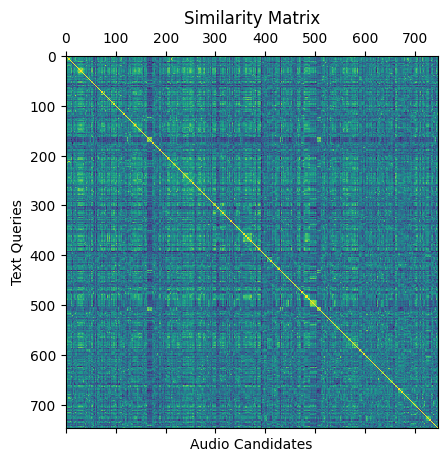

In [49]:
def calculate_recall(similarity_matrix, k):
    n_samples = similarity_matrix.shape[0]
    correct_predictions = 0
    for i in range(n_samples):
        # sort candidates by similarity  and check if the matching text is among the top-k
        top_k_indices = torch.topk(similarity_matrix[i, :], k=k, dim=0).indices
        if i in top_k_indices:
            correct_predictions += 1
    return correct_predictions / n_samples

# Put model in evaluation mode
model.eval()

all_audio_embeddings = []
all_text_embeddings = []

# Extract embeddings for the evaluation dataset
for batch in tqdm(eval_loader, desc="Extracting embeddings"):
    x_a = batch["audio_rep"].to(device)
    x_t = batch["text_rep"].to(device)

    with torch.no_grad():
        z_a, z_t = model(x_a, x_t)

    all_audio_embeddings.append(z_a.cpu())
    all_text_embeddings.append(z_t.cpu())

all_audio_embeddings = torch.cat(all_audio_embeddings, dim=0)
all_text_embeddings = torch.cat(all_text_embeddings, dim=0)

# Normalize embeddings for cosine similarity
all_audio_embeddings = F.normalize(all_audio_embeddings, dim=1)
all_text_embeddings = F.normalize(all_text_embeddings, dim=1)

# Calculate similarity matrix (text queries vs audio candidates)
similarity_matrix = torch.matmul(all_text_embeddings, all_audio_embeddings.T)

print("")

# Calculate Recall@1
recall_1 = calculate_recall(similarity_matrix, k=1)
print(f"Recall@1: {recall_1:.4f}")

# Calculate Recall@10
recall_10 = calculate_recall(similarity_matrix, k=10)
print(f"Recall@10: {recall_10:.4f}")

plt.matshow(similarity_matrix)
plt.title("Similarity Matrix")
plt.xlabel("Audio Candidates")
plt.ylabel("Text Queries")